# Determining the cost of vehicles

The used car sales service "Never Crashed, Never Painted" is developing an app to attract new customers. It allows users to quickly find out the market value of their car. You have historical data at your disposal: technical specifications, configurations, and car prices. You need to build a model to determine the cost.

The client values:

- prediction quality;  
- prediction speed;  
- training time.

# Imports

In [2]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
print(sklearn.__version__)

1.6.1


In [4]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Data Overview

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.info()
display(data.head())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div class="alert alert-info">

Uploaded the dataset. It's very large — 354 thousand entries, but there are quite a few missing values, as well as unnecessary columns and abnormal values. Let's get things in order.

## Data Preprocessing

### Duplicate сheck

In [7]:
print(data.duplicated().sum())

4


In [8]:
data = data.drop_duplicates()

### Removing unnecessary columns

In [9]:
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

In [10]:
print(data[['RegistrationMonth', 'Price']].corr())

                   RegistrationMonth    Price
RegistrationMonth            1.00000  0.11058
Price                        0.11058  1.00000


In [11]:
print(data['PostalCode'].value_counts())

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64


In [12]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 
                  'RegistrationMonth', 'PostalCode'], axis=1)

<div class='alert alert-info'>

Removed columns with time logs, as well as the registration month (due to weak correlation), number of images (all are 0, better to inform those collecting the data), and postal code (too many unique values, might break the training).

### Type сasting

In [13]:
data = data.astype({'Price': 'int32', 'RegistrationYear': 'int32', 'Power': 'int32', 'Kilometer': 'int32'})

In [14]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int32 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int32 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int32 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int32 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int32(4), object(6)
memory usage: 24.3+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div class="alert alert-info">

Converted int64 to int32 to speed up model training.

### RegistrationYear

In [15]:
print(data['RegistrationYear'].min())
print(data['RegistrationYear'].max())

1000
9999


In [16]:
print(data.query('RegistrationYear < 1986 or RegistrationYear > 2016').shape[0])

20734


In [17]:
data = data.query('1986 <= RegistrationYear <= 2016')

<div class="alert alert-info">

Started with RegistrationYear. Kept cars from the last 30 years. Anything older or in the future is too difficult to predict.

### Power

In [18]:
display(data['Power'].value_counts().sort_index())

0        34613
1           27
2            9
3            7
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 694, dtype: int64

In [19]:
data[data['Power']>600].sample(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
101186,600,wagon,2000,manual,1753,focus,150000,gasoline,ford,no
323887,7499,coupe,2004,manual,1707,cooper,150000,petrol,mini,no
322683,8600,other,2007,auto,3500,transporter,150000,NaN,volkswagen,NaN
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN
28942,300,wagon,1996,manual,1999,golf,10000,petrol,volkswagen,NaN
117936,3999,sedan,2000,manual,1801,NaN,150000,petrol,audi,no
121124,650,wagon,1997,auto,3199,e_klasse,30000,petrol,mercedes_benz,NaN
341320,1899,other,2006,manual,7518,berlingo,125000,petrol,citroen,yes
59887,300,sedan,2004,manual,1002,NaN,150000,NaN,ford,yes
261022,900,wagon,1992,auto,1992,touareg,150000,NaN,volkswagen,NaN


In [20]:
data[data['Power']<35].sample(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
285566,6200,sedan,2009,NaN,0,3er,125000,gasoline,bmw,NaN
25975,3900,sedan,2007,NaN,0,a4,150000,gasoline,audi,no
307983,0,NaN,1995,NaN,0,NaN,5000,petrol,fiat,yes
347113,2599,NaN,2016,manual,0,sprinter,150000,gasoline,mercedes_benz,yes
328979,2000,bus,1991,manual,0,transporter,150000,NaN,volkswagen,no
335112,5555,sedan,1999,NaN,0,e_klasse,150000,NaN,mercedes_benz,NaN
176109,950,NaN,2016,NaN,0,antara,150000,petrol,opel,no
248973,150,NaN,1995,NaN,0,NaN,150000,petrol,renault,NaN
128421,10000,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
223179,50,NaN,2005,NaN,0,transporter,5000,NaN,volkswagen,NaN


In [21]:
data = data.query('30 <= Power <= 600')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298120 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             298120 non-null  int32 
 1   VehicleType       286396 non-null  object
 2   RegistrationYear  298120 non-null  int32 
 3   Gearbox           292587 non-null  object
 4   Power             298120 non-null  int32 
 5   Model             287018 non-null  object
 6   Kilometer         298120 non-null  int32 
 7   FuelType          281781 non-null  object
 8   Brand             298120 non-null  object
 9   Repaired          253912 non-null  object
dtypes: int32(4), object(6)
memory usage: 20.5+ MB
None


<div class="alert alert-info">
    
Kept cars with more than 30 years and over 600 horsepower. The number of null values in other columns significantly decreased, which confirms the "poor quality" of most such listings.

**sonstige_autos** and **trabant** stand out in this regard compared to others, let's check the brands.

### Brand

In [22]:
data['Brand'].value_counts()

volkswagen        64779
opel              33010
bmw               32761
mercedes_benz     26992
audi              26117
ford              20856
renault           14177
peugeot            9534
fiat               7632
seat               5976
skoda              4977
mazda              4797
smart              4516
citroen            4219
nissan             4114
toyota             4020
hyundai            3138
mini               2977
volvo              2823
mitsubishi         2559
honda              2424
kia                2130
suzuki             1970
alfa_romeo         1958
chevrolet          1372
sonstige_autos     1244
chrysler           1186
dacia               804
subaru              661
daihatsu            637
jeep                554
porsche             544
saab                471
land_rover          444
jaguar              422
daewoo              414
rover               379
lancia              371
lada                138
trabant              23
Name: Brand, dtype: int64

In [23]:
sonstige_autos = data[data['Brand'] == 'sonstige_autos']
display(sonstige_autos.describe())
display(sonstige_autos.sample(10))

,Price,RegistrationYear,Power,Kilometer
count,1244.000000,1244.000000,1244.000000,1244.000000
mean,6982.887460,2002.197749,175.444534,117094.051447
std,5509.200653,6.722122,82.612751,45032.124012
min,0.000000,1986.000000,30.000000,5000.000000
25%,2498.750000,1998.000000,120.000000,90000.000000
50%,5770.000000,2003.000000,156.000000,150000.000000
75%,10800.000000,2007.000000,223.250000,150000.000000
max,20000.000000,2016.000000,551.000000,150000.000000


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
181619,3690,sedan,2004,manual,155,NaN,150000,petrol,sonstige_autos,no
257327,350,sedan,1989,auto,126,NaN,30000,petrol,sonstige_autos,yes
283298,0,small,1992,manual,90,NaN,150000,petrol,sonstige_autos,NaN
296973,14300,other,2011,manual,160,NaN,150000,gasoline,sonstige_autos,no
297959,4500,other,2006,manual,136,NaN,150000,gasoline,sonstige_autos,no
310769,500,NaN,1995,manual,60,NaN,150000,NaN,sonstige_autos,no
272280,12500,suv,2004,auto,211,NaN,150000,hybrid,sonstige_autos,no
8714,2490,convertible,2000,manual,120,NaN,150000,petrol,sonstige_autos,no
90934,18200,sedan,2006,auto,400,NaN,125000,petrol,sonstige_autos,no
341443,12500,suv,2005,auto,211,NaN,150000,hybrid,sonstige_autos,no


In [24]:
trabant = data[data['Brand']=='trabant']
trabant.sample(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2953,2500,sedan,1989,manual,41,other,150000,petrol,trabant,no
100862,0,sedan,1989,manual,36,601,5000,NaN,trabant,NaN
172263,2500,sedan,1989,manual,41,other,5000,petrol,trabant,NaN
55888,2490,wagon,1990,manual,41,other,60000,petrol,trabant,no
184799,14500,convertible,1993,manual,41,other,5000,petrol,trabant,no
237648,0,wagon,1988,manual,50,other,50000,petrol,trabant,NaN
322695,1500,wagon,1990,manual,39,other,50000,petrol,trabant,no
239919,500,sedan,1986,manual,35,601,40000,petrol,trabant,yes
305451,2000,small,2004,manual,60,NaN,150000,gasoline,trabant,yes
78755,4799,small,1986,manual,50,601,5000,petrol,trabant,no


In [25]:
data = data[~data['Brand'].isin(['sonstige_autos', 'trabant'])]

<div class="alert alert-info">

Cars with poor data include those from the brand **sonstige_autos**, which, translated from German, means **other cars**, mainly consisting of vehicles with high mileage. A mix of completely different cars is unnecessary, so I removed them from the dataset.

Also removed **trabant**, since the factory is closed and no longer produces cars, and vehicles there typically have mileage of 150,000 or more, likely much higher.

There are no brand duplicates.

### Price

In [26]:
data['Price'].value_counts().sort_index()

0        6140
1         622
2           7
3           4
5           7
         ... 
19995      10
19997       1
19998       6
19999     256
20000     229
Name: Price, Length: 3550, dtype: int64

<AxesSubplot:>

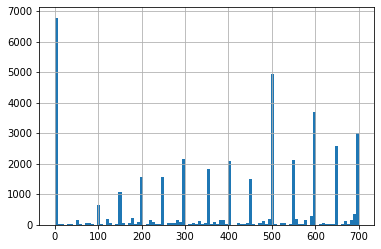

In [27]:
data['Price'].hist(bins=100, range=(0, 700))

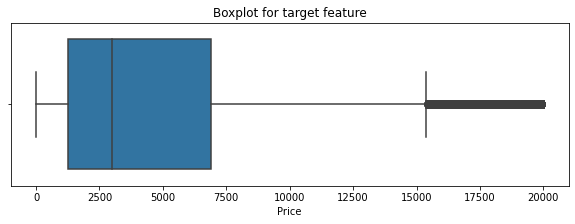

In [28]:
plt.figure(figsize=(10,3))
sns.boxplot(x=data['Price'], orient='h')
plt.title('Boxplot for target feature')
plt.show()

In [29]:
data['Price'].quantile([0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.05      300.0
0.25     1250.0
0.50     2999.0
0.75     6900.0
0.95    14990.0
0.99    18900.0
Name: Price, dtype: float64

In [30]:
data = data.query('200 < Price')

<div class="Alert alert-info">
    
For cars priced above 200 euros, it probably makes sense to care about the sale. If the model predicts the price incorrectly and the actual price turns out to be 100 dollars instead of 200, I don't think the buyer will be too upset.

As for cars above 15,000 euros, I will leave them as is for now, since the maximum price in the data is 20,000 euros, which is not really a limit, even for 2016.

### Kilometer

In [31]:
data['Kilometer'].value_counts()

150000    190143
125000     30925
100000     12216
90000       9940
80000       8678
70000       7485
60000       6564
50000       5429
40000       4323
30000       3683
20000       3041
5000        2350
10000        819
Name: Kilometer, dtype: int64

<div class="alert alert-info">
    
Most cars have mileage of 150,000 km+, with no outliers or anomalies.

### Processing null

In [32]:
data.isna().sum()

Price                   0
VehicleType          9863
RegistrationYear        0
Gearbox              4814
Power                   0
Model                8707
Kilometer               0
FuelType            14183
Brand                   0
Repaired            39962
dtype: int64

In [33]:
data = data.dropna(subset=['Gearbox'])
data.isna().sum().sum()

68015

In [34]:
data['VehicleType'].fillna('unknown', inplace=True)
data['Model'].fillna('unknown', inplace=True)
data['FuelType'].fillna('unknown', inplace=True)
data['Repaired'].fillna('yes', inplace=True)
data.isna().sum().sum()

0

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280782 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             280782 non-null  int32 
 1   VehicleType       280782 non-null  object
 2   RegistrationYear  280782 non-null  int32 
 3   Gearbox           280782 non-null  object
 4   Power             280782 non-null  int32 
 5   Model             280782 non-null  object
 6   Kilometer         280782 non-null  int32 
 7   FuelType          280782 non-null  object
 8   Brand             280782 non-null  object
 9   Repaired          280782 non-null  object
dtypes: int32(4), object(6)
memory usage: 19.3+ MB


<div class="alert alert-info">
    
Decided to remove **Gearbox** instead of filling it, as it can be binary encoded, and many null values were cleaned up in other columns.

Replaced null in **Repaired** with "yes", as the absence of repair information is treated as a repair that is being hidden.

For other columns, replaced null with "unknown", adding one more category.

### FuelType

In [36]:
print(data['FuelType'].unique())

['gasoline' 'petrol' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [37]:
data['FuelType'] = data['FuelType'].replace({
    'petrol' : 'gasoline',
    'lpg' : 'gas',
    'cng' : 'gas',
    'unknown' : 'other'
})
print(data['FuelType'].unique())

['gasoline' 'other' 'gas' 'hybrid' 'electric']


<div class="alert alert-info">
    
Merged gasoline and petrol as they are the same. Combined lpg and cng into gas, and assigned unknown to other, as both represent unclear information.

### Binary Feature Encoding

In [38]:
data['Gearbox'].value_counts()

manual    223890
auto       56892
Name: Gearbox, dtype: int64

In [39]:
ord_encoder = OrdinalEncoder()
data['Gearbox'] = ord_encoder.fit_transform(data[['Gearbox']])
data['Repaired'] = ord_encoder.fit_transform(data[['Repaired']])

### Correlation

In [40]:
data.corr()['Price']

Price               1.000000
RegistrationYear    0.605841
Gearbox            -0.254055
Power               0.509117
Kilometer          -0.399976
Repaired           -0.243089
Name: Price, dtype: float64

### Preprocessing conclusions

<div class="alert alert-info">
    
During preprocessing:
1. Removed columns: DateCrawled, DateCreated, LastSeen, NumberOfPictures, RegistrationMonth, PostalCode. The last one could have been useful if transformed into regions to avoid too many unique values.
2. Converted numerical types to int32 to save memory.
3. Kept only cars from the last 30 years, 1986-2016.
4. Kept only cars with horsepower between 35 and 600.
5. Excluded models from the "other cars" category and trabant.
6. Removed cars priced below 200 euros.
7. Removed all records without information on the gearbox; where repair info was missing, assumed it was repaired.
8. Replaced null in other categories with "unknown."
9. Encoded Gearbox and Repaired.

After processing, the dataset contains **280,782 records**, which is quite substantial. The strongest correlations with price are observed from **registration year, engine power, and mileage**.

## Model Training

In [42]:
X = data.drop(columns=['Price'])
y = data['Price']

cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(exclude='object').columns.tolist()

X_sample, X_valid, y_sample, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
print(f"Validation set created")

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.25, random_state=42)
print(f"Test set created")


results = []

Validation set created
Test set created


<div class="alert alert-info">
    
Created validation and test sets. The data split ratio is 3:1:1.

### LightGBM OHE

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train[cat_features]), columns=ohe.get_feature_names_out(cat_features), index=X_train.index)
X_valid_cat_ohe = pd.DataFrame(ohe.transform(X_valid[cat_features]), columns=ohe.get_feature_names_out(cat_features), index=X_valid.index)

X_train_ohe = pd.concat([X_train[num_features], X_train_cat_ohe], axis=1)
X_valid_ohe = pd.concat([X_valid[num_features], X_valid_cat_ohe], axis=1)

lgbm_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1]
}

lgbm_grid = GridSearchCV(
    LGBMRegressor(random_state=42), 
    param_grid=lgbm_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgbm_grid.fit(X_train_ohe, y_train)
best_params = lgbm_grid.best_params_
print(f"Best params for LGBM + OneHot: {best_params}")

model = LGBMRegressor(random_state=42, **best_params)
start_train = time.time()
model.fit(X_train_ohe, y_train)
train_time = time.time() - start_train

start_pred = time.time()
preds = model.predict(X_valid_ohe)
pred_time = time.time() - start_pred
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
results.append(["LGBM + OneHot", rmse, train_time, pred_time])

Best params for LGBM + OneHot: {'learning_rate': 0.1, 'n_estimators': 100}


### LightGBM OE

In [44]:
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord = X_train.copy()
X_valid_ord = X_valid.copy()
X_train_ord[cat_features] = ord.fit_transform(X_train[cat_features])
X_valid_ord[cat_features] = ord.transform(X_valid[cat_features])

cat_indices = [X_train_ord.columns.get_loc(col) for col in cat_features]

lgbm_ord_grid = GridSearchCV(
    LGBMRegressor(max_depth=10, num_leaves=31, random_state=42), 
    param_grid=lgbm_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgbm_ord_grid.fit(X_train_ord, y_train, categorical_feature=cat_indices)
print(f"Best params for LGBM + Ordinal: {lgbm_ord_grid.best_params_}")

model = LGBMRegressor(max_depth=10, num_leaves=31, random_state=42, **best_params)
start_train = time.time()
model.fit(X_train_ord, y_train, categorical_feature=cat_indices)
train_time = time.time() - start_train


start_pred = time.time()
preds = model.predict(X_valid_ord)
pred_time = time.time() - start_pred
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
results.append(["LGBM + Ordinal", rmse, train_time, pred_time])

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_fe

Best params for LGBM + Ordinal: {'learning_rate': 0.1, 'n_estimators': 100}


### CatBoost 

In [45]:
catboost_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1],
    'depth': [6, 10]
}

catboost_grid = GridSearchCV(
    CatBoostRegressor(verbose=0, random_seed=42),
    param_grid=catboost_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

catboost_grid.fit(X_train_ord, y_train)
best_params = catboost_grid.best_params_
print(f"Best params for CatBoost + Ordinal: {best_params}")

cat_boost = CatBoostRegressor(verbose=0, random_seed=42, **best_params)
start_train = time.time()
cat_boost.fit(X_train_ord, y_train)
train_time = time.time() - start_train

start_pred = time.time()
preds = cat_boost.predict(X_valid_ord)
pred_time = time.time() - start_pred
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
results.append(["CatBoost", rmse, train_time, pred_time])

Best params for CatBoost + Ordinal: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}


### Linear Regression

In [46]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_valid_scaled = scaler.transform(X_valid_ohe)

lr = LinearRegression()
start_train = time.time()
lr.fit(X_train_scaled, y_train)
train_time = time.time() - start_train

start_pred = time.time()
preds = lr.predict(X_valid_scaled)
pred_time = time.time() - start_pred
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
results.append(["LinearRegression + OneHot", rmse, train_time, pred_time])

## Model Analysis

In [47]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "Train time (s)", "Predict time (s)"])
display(results_df.sort_values("RMSE"))

,Model,RMSE,Train time (s),Predict time (s)
1,LGBM + Ordinal,1552.879588,4.398282,0.609611
2,CatBoost,1574.415474,9.600533,0.045522
0,LGBM + OneHot,1619.478833,5.796752,0.906754
3,LinearRegression + OneHot,2326.225777,14.387534,0.112378


### Analysis conclusion

<div class="alert alert-info">
    
The linear regression model trained the fastest, partly due to the lack of parameter tuning, but it also gives the highest error. Therefore, we discard it. For the other models, the errors are generally comparable, so let's see about the time.

LGBM + Ordinal performs much better than LGBM + OneHot in terms of training time and predictions, which is related to the library's specifics.

As for CatBoost, it has the best prediction speed, although it has the longest training time. Since this long training time is due to parameter tuning, we will try to train and test this model using cross-validation with the best parameters.

## BestModel (CatBoost)

In [48]:
X_test_ord = X_test.copy()
X_test_ord[cat_features] = ord.transform(X_test[cat_features])

start_train = time.time()
cat_boost.fit(X_train_ord, y_train)
train_time = time.time() - start_train

start_pred = time.time()
preds = cat_boost.predict(X_test_ord)
pred_time = time.time() - start_pred
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print(f"CatBoost Final RMSE: {rmse}, train time: {train_time}, pred time: {pred_time}")

CatBoost Final RMSE: 1571.8987196625642, train time: 9.583175897598267, pred time: 0.0447840690612793


## Final conclision

### Project description

The project aimed to create a model for predicting car prices based on historical data containing technical specifications, configurations, and car prices. The goal was to develop a solution that would provide:

1. High prediction quality  
2. Fast data processing and model training

### Stages

**Data Preprocessing**  
1. The data was cleaned, and unnecessary columns were removed.  
2. Outliers and anomalies were corrected (e.g., cars with a registration year before 1986 and mileage below 30 horsepower were removed).  
3. Missing data was handled (filling and removal), and categorical features were encoded.  

**Model Training**  
1. Several models were tested: linear regression, LGBM (with OHE and Ordinal encoding), and CatBoost.  
2. The training process was carried out with hyperparameter optimization and cross-validation to assess model quality.  

**Quality Assessment**  

The models were evaluated using the RMSE (Root Mean Squared Error) metric, training time, and prediction time.  

### Conclusions and Suggestions

The best results were achieved by the **CatBoost** model.

The CatBoost model showed the best accuracy with the lowest RMSE error of 1546.90.

Despite longer training times, the prediction speed remained high, making the model suitable for real-time use.

**Improvement Recommendations**:  
1. Consider adding additional features (e.g., regional data or updates on car brands).  
2. Optimize training time by utilizing more powerful computing resources or distributed learning technologies.  
3. It is recommended to periodically update the model with new data to maintain prediction accuracy.  
4. Monitor model performance during production deployment to make adjustments in case of data or requirement changes.

### Conclusion

The project successfully addresses the task of estimating the prices of used cars and can be used to attract customers to the service.